In [1]:
import numpy as np 
import pandas as pd
import parameters as pa
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow.keras import layers
tf.executing_eagerly()

# Just disables the warning, doesn't enable AVX/FMA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
data = np.array(pd.read_csv(pa.FILE_NAME).values[:, pa.OHLC], dtype="float32")

def plot_data(data):
    plt.figure(figsize=(15,6))
    plt.plot(data)

weights = np.exp(np.linspace(-1., 0., 5))
weights /= weights.sum()
exp =  np.convolve(data, weights, mode='full')[:len(data)]
exp[:5] = exp[5]
data = exp

mean_train = np.mean(data[6000:10000])

# train from 1995.08.23 to 2011.03.15
train_data = data[6000:10000]/np.mean(data[6000:10000])
test_data = data[10000:]/np.mean(data[10000:])

In [3]:
class Attention(tf.keras.Model):
    def __init__(self, rnn_units, batch_size, time_step, input_size, output_size):
        super(Attention, self).__init__()
        self.units = rnn_units
        self.batch_size = batch_size
        self.time_step = time_step
        self.input_step = input_size
        self.output_size = output_size
        
        self.lstm = tf.keras.layers.LSTM(self.units, 
                                         return_sequences = True, 
                                         return_state = True,
                                         stateful = True,
                                         recurrent_initializer='glorot_uniform')
        
        self.Wh = tf.keras.layers.Dense(self.units)
        self.Ws = tf.keras.layers.Dense(self.units)
        self.Wx = tf.keras.layers.Dense(1)
        self.V = tf.keras.layers.Dense(1)
        self.O = tf.keras.layers.Dense(self.output_size)
    
    def call(self, x, hidden, state):
        
        # hidden shape (batch, units) to (batch,1,units)
        hidden = tf.expand_dims(hidden, 1)
        # x shape (batch, time_step, 1)
        x = tf.expand_dims(x,0)
        
        score = self.V(tf.nn.tanh(self.Wx(x) + self.Wh(hidden) + self.Ws(state)))
        # attention shape = (batch, time_step, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        encoder_outputs, state_h, state_c = self.lstm(x*attention_weights) 
        output = self.O(state_h)
        
        return attention_weights,state_h, state_c, output
    
    def init_hidden_state(self):
        hidden = tf.zeros((self.batch_size, self.units))
        state = tf.zeros((self.batch_size, self.time_step, self.units))
        return hidden, state
        

In [4]:
lstm_size = 128
time_step = 30
batch_size = 1
output_size = 1
input_size = 1
shift = 1

In [5]:
tf_train = tf.data.Dataset.from_tensor_slices(train_data[-250:]).window(size=time_step+shift, shift=shift, drop_remainder=True).flat_map(
        lambda x: x.batch(time_step+shift))

tdata = tf_train.map(lambda x: tf.reshape(x[:time_step],[time_step,1]))
labels = tf_train.map(lambda x: x[-shift:])

In [6]:
attention_model = Attention(lstm_size, batch_size, time_step, input_size,output_size)

optimizer=tf.keras.optimizers.SGD(0.0001)

def train_step(inp, target, hidden,state):
    loss = 0
    pred = 0
    with tf.GradientTape() as tape:
        for i,t in zip(inp,target):
            attention_weight, hidden, state, output = attention_model(tf.cast(i, tf.float32), hidden, state)
            loss += tf.keras.losses.mean_squared_error(t, output)
            pred += 1
    variables = attention_model.trainable_variables
    grads = tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss/pred

EPOCHS = 15
early_stopping = [100]
patience = [2,0]
for epoch in range(EPOCHS):
    start = time.time()
    hidden, state = attention_model.init_hidden_state()
    loss = train_step(tdata,labels, hidden, state)
    
    early_stopping.append(loss)
    
    if(early_stopping[epoch+1] >= early_stopping[epoch]):
        patience[1]+=1
    if(patience[0]<=patience[1]):
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,loss.numpy()[0]))
        break;    
    if(epoch%2 == 0):
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,loss.numpy()[0]))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.2143
Time taken for 1 epoch 30.890124082565308 sec

Epoch 3 Loss 0.5558
Time taken for 1 epoch 40.31746959686279 sec

Epoch 5 Loss 0.2100
Time taken for 1 epoch 32.559616804122925 sec

Epoch 7 Loss 0.0545
Time taken for 1 epoch 33.33490037918091 sec

Epoch 9 Loss 0.0102
Time taken for 1 epoch 25.117180109024048 sec

Epoch 11 Loss 0.0030
Time taken for 1 epoch 14.685878038406372 sec

Epoch 13 Loss 0.0022
Time taken for 1 epoch 19.38339400291443 sec

Epoch 15 Loss 0.0022
Time taken for 1 epoch 20.823322057724 sec



In [7]:
def evaluate(data):
    hidden, state = attention_model.init_hidden_state()
    pred = []
    
    for i in data:
        attention_weight, hidden, state, output = attention_model(tf.cast(i, tf.float32), hidden, state)
        pred.append(output)
    
    return pred

In [8]:
def plot_tensor_data(real, pred):
    img_pred = []
    for i in pred:
        img_pred = np.concatenate((img_pred, i[0].numpy()))
        
    scaler = MinMaxScaler(feature_range=(0,1))
    
    scaler.fit(np.array([img_pred]).T)
    img_pred = scaler.transform(np.array([img_pred]).T)
    
    scaler.fit(np.array([real]).T)
    img_real = scaler.transform(np.array([real]).T)
    
    plt.figure(figsize=(15,6))
    plt.plot(img_real)
    plt.plot(img_pred, color='darkorange')

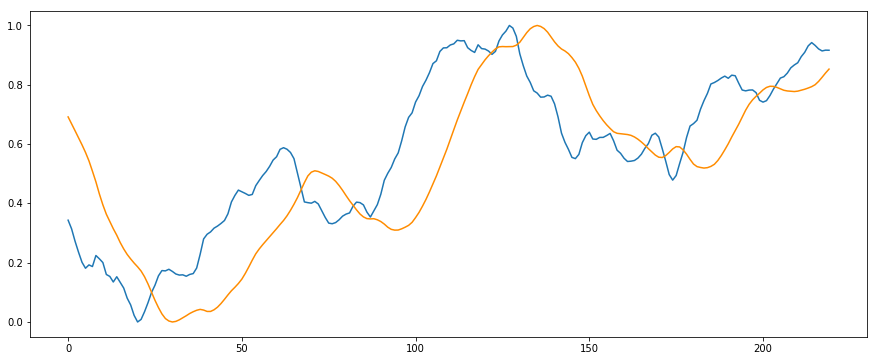

In [ ]:
plot_tensor_data(train_data[-220:], evaluate(tdata))

In [ ]:
tf_test = tf.data.Dataset.from_tensor_slices(test_data).window(size=time_step+shift, 
                shift=shift, drop_remainder=True).flat_map(lambda x: x.batch(time_step+shift))

testd = tf_test.map(lambda x: tf.reshape(x[:time_step],[time_step,1]))
testl = tf_test.map(lambda x: x[-shift:])

In [ ]:
plot_tensor_data(test_data[30:], evaluate(testd))

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})

def plot_weights(data):
    pred = tf.reshape(data[:30],[time_step,1])
    hidden, state = attention_model.init_hidden_state()
    attention_weight, hidden, state, output = attention_model(tf.cast(pred, tf.float32), hidden, state)
    a = attention_weight[0].numpy()
    norm = (a - np.min(a))/np.ptp(a)
    #data = (data - np.min(data))/np.ptp(data)
    ax1 = sns.heatmap(norm.T,cmap="Blues" ,cbar=False)
    ax2 = ax1.twinx()
    ax2.plot(data, color='darkorange', linewidth=3)

In [ ]:
plot_weights(test_data[250:280])

In [ ]:
plt.plot(test_data[250:290])

In [ ]:
plot_weights(test_data[-245:-215])

In [ ]:
plt.plot(test_data[-250:-210])

In [ ]:
# trend
plot_weights(test_data[1838:1868])

In [ ]:
plt.plot(test_data[1838:1873])

In [ ]:
# breaking through resistance
plot_weights(test_data[1646:1676])

In [ ]:
plt.plot(test_data[1645:1685])

In [ ]:
predicts=evaluate(testd)

In [ ]:
pred12 = []
test_val = []
for i,v in zip(predicts, testl):
    pred12.append(i[0].numpy())
    test_val.append(v.numpy())
    
scaler = MinMaxScaler(feature_range=(0,1))
    
scaler.fit(np.array([pred12]).T)
pred12 = scaler.transform(np.array([pred12]).T)
    
scaler.fit(np.array([test_val]).T)
test_val = scaler.transform(np.array([test_val]).T)

In [ ]:
tf.keras.losses.mean_absolute_error(np.array(test_val), np.array(pred12))